
Running simulations for lattice size L = 2...

Running simulations for lattice size L = 5...

Running simulations for lattice size L = 10...

Running simulations for lattice size L = 20...

Running simulations for lattice size L = 25...

Running simulations for lattice size L = 30...


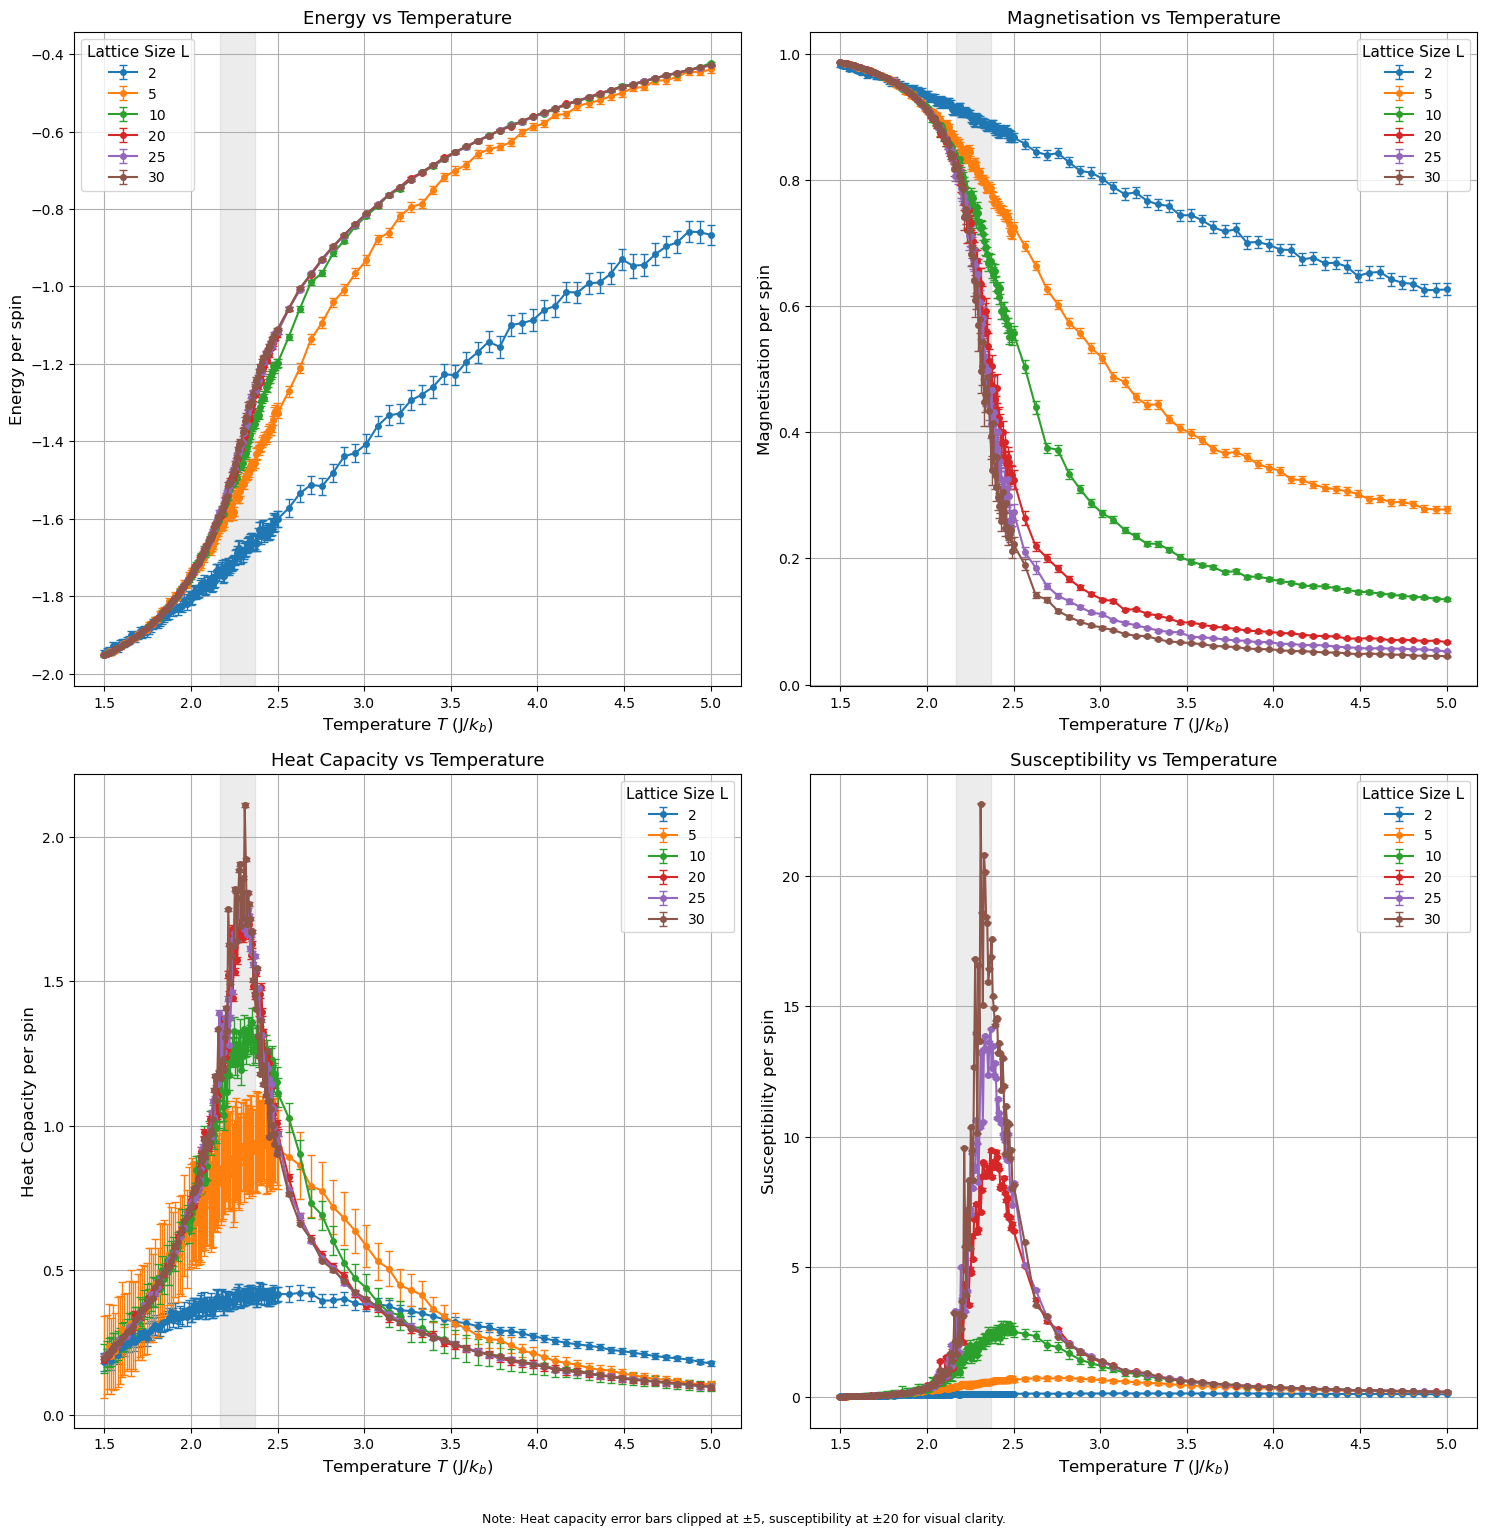


Extracted Key Values for Each Lattice Size:

Lattice Tc (Heat Cap)     ΔTc (Heat Cap)    Tc (Suscept.)     ΔTc (Suscept.)    Peak C      Peak χ      E(low T)    E(high T)   
--------------------------------------------------------------------------------------------------------------------------------
2       2.392             0.026             3.141             0.332             1.721       0.611       -7.790      -3.468      
5       2.386             2.031             2.628             0.571             24.047      18.317      -48.767     -10.991     
10      2.354             0.202             2.430             0.014             135.748     273.792     -195.153    -42.338     
20      2.285             1.031             2.367             0.113             708.403     3789.224    -780.434    -171.161    
25      2.259             0.484             2.367             0.062             1132.802    8844.786    -1219.136   -267.837    
30      2.310             0.288             2.310  

In [1]:
# Takes about 6.5mins to run on my laptop

import numpy as np
import matplotlib.pyplot as plt
from numba import jit

#---------------
# Initialization
#---------------
def initialize_lattice(L, rng):
    """Creates an LxL spin lattice with random +1 or -1 values using the provided rng."""
    return rng.choice(np.array([-1, 1], dtype=np.int8), size=(L, L))

#-------------------
# Energy Calculation
#-------------------
# Introduced to the idea of a jit compiler by my lab partner Michael Shorkey (py15mjvs@leeds.ac.uk)
# I proceeded to do more research myself and read through the documentation, finally using @jit(nopython=True) for the fastest speed.
# Documentation accessible at: https://numba.pydata.org/numba-doc/dev/user/jit.html
@jit(nopython=True, cache = True)
def calculate_energy(lattice, J=1):
    L = lattice.shape[0]
    energy = 0.0
    for i in range(L):
        for j in range(L):
            S = lattice[i, j]
            # Inspiration for nearest-neighbour implementation from:
            # Rajesh Rinet - Ising Model - Github
            # Accessible at: https://rajeshrinet.github.io/blog/2014/ising-model/#Ising-model
            neighbours = (lattice[(i + 1) % L, j] + lattice[i, (j + 1) % L] +
                          lattice[(i - 1) % L, j] + lattice[i, (j - 1) % L])
            energy += -J * S * neighbours
    return energy / 2.0

@jit(nopython=True, cache=True)
def calculate_magnetization(lattice):
    return np.sum(lattice)

@jit(nopython=True, cache=True)
def energy_change(lattice, i, j, J=1):
    L = lattice.shape[0]
    S = lattice[i, j]
    neighbours = (lattice[(i + 1) % L, j] + lattice[i, (j + 1) % L] +
                  lattice[(i - 1) % L, j] + lattice[i, (j - 1) % L])
    return 2 * J * S * neighbours

#----------------------------------------
# JIT-Compatible Metropolis Step Function
#----------------------------------------
@jit(nopython=True, cache=True)
def metropolis_step_jit(lattice, T, rand_i, rand_j, rand_vals, J=1):
    L = lattice.shape[0]
    for idx in range(L * L):
        i = rand_i[idx]
        j = rand_j[idx]
        dE = energy_change(lattice, i, j, J)
        if dE <= 0 or rand_vals[idx] < np.exp(-dE / T):
            lattice[i, j] *= -1
    return lattice

# Wrapper to use RNG outside jit
def metropolis_step(lattice, T, rng, J=1):
    L = lattice.shape[0]
    # Pre-generate random numbers deterministically using the provided RNG.
    rand_i = rng.integers(0, L, size=L*L)
    rand_j = rng.integers(0, L, size=L*L)
    rand_vals = rng.random(L*L)
    return metropolis_step_jit(lattice, T, rand_i, rand_j, rand_vals, J)

#------------------------------
# Autocorrelation & Error Bars
#------------------------------
@jit(nopython=True, cache=True)
def autocorrelation_time_jit(data):
    n = len(data)
    mean = np.mean(data)
    var = np.var(data)
    autocorr = np.zeros(n)
    
    # Compute the normalized autocorrelation function
    for t in range(n): # Loop over time lags
        s = 0.0
        for i in range(n - t): # Sum over pairs separated by lag t
            s += (data[i] - mean) * (data[i + t] - mean)
        autocorr[t] = s / ((n - t) * var) # Normalize

    # Determine the cutoff time (T_cut) where the autocorrelation first becomes non-positive
    T_cut = n
    for t in range(1, n):
        if autocorr[t] <= 0.0:
            T_cut = t
            break

    tau_int = 0.5
    for t in range(1, T_cut):
        tau_int += autocorr[t]

    return tau_int

#---------------
# Standard Error
#---------------

@jit(nopython=True, cache=True)
def standard_error_jit(data):
    N = len(data)
    mean = np.mean(data)
    sigma = 0.0
    for i in range(N):
        sigma += (data[i] - mean) ** 2
    sigma = np.sqrt(sigma / (N - 1))
    tau_int = autocorrelation_time_jit(data)
    SE = sigma * np.sqrt(2 * tau_int / N)
    return SE, tau_int

#--------------------------------
# Precompile JIT Functions
#--------------------------------
def precompile_jit_functions():
    # Create a small dummy lattice and data to trigger compilation.
    dummy_lattice = np.ones((2, 2), dtype=np.int8)
    dummy_rng = np.random.default_rng(123)
    dummy_rand_i = dummy_rng.integers(0, 2, size=4)
    dummy_rand_j = dummy_rng.integers(0, 2, size=4)
    dummy_rand_vals = dummy_rng.random(4)
    # Call each jit function with dummy data.
    calculate_energy(dummy_lattice)
    calculate_magnetization(dummy_lattice)
    energy_change(dummy_lattice, 0, 0)
    metropolis_step_jit(dummy_lattice, 1.0, dummy_rand_i, dummy_rand_j, dummy_rand_vals)
    autocorrelation_time_jit(np.array([1.0, -1.0, 1.0, -1.0]))
    standard_error_jit(np.array([1.0, -1.0, 1.0, -1.0]))

# Call the precompilation routine before starting simulations.
precompile_jit_functions()

#-------------------
# Simulation Wrapper
#-------------------
def run_simulation(L, T, n_steps, equilibration_steps=5000, J=1):
    # Ensure that the seed is constructed deterministically for a given L and T.
    seed = 42 + L * 1000 + int(T * 100)
    rng = np.random.default_rng(seed)
    lattice = initialize_lattice(L, rng)
    
    # Equilibration phase
    for _ in range(equilibration_steps):
        metropolis_step(lattice, T, rng, J)

    energy_list = []
    magnetization_list = []

    for _ in range(n_steps):
        metropolis_step(lattice, T, rng, J)
        energy_list.append(calculate_energy(lattice, J))
        magnetization_list.append(np.abs(calculate_magnetization(lattice)))

    energy_list = np.array(energy_list)
    magnetization_list = np.array(magnetization_list)

    stride = 10
    E_sub = energy_list[::stride]
    M_sub = magnetization_list[::stride]

    mean_E = np.mean(energy_list)
    mean_M = np.mean(magnetization_list)

    energy_std, tau_E = standard_error_jit(E_sub)
    mag_std, tau_M = standard_error_jit(M_sub)

    return lattice, mean_E, energy_std, mean_M, mag_std, energy_list, magnetization_list, tau_E, tau_M, E_sub, M_sub

#--------------------------------
# Simulation Parameters
#--------------------------------
lattice_sizes = [2, 5, 10, 20, 25, 30]  # different lattice sizes
T_low = np.linspace(1.5, 2.0, 40)
T_crit = np.linspace(2.0, 2.5, 80)   # denser near 2.269
T_high = np.linspace(2.5, 5.0, 40)
T_values = np.unique(np.concatenate([T_low, T_crit, T_high]))  # temperature range
n_steps = 15000                        # number of Monte Carlo steps per T

# Dictionary to store results for each lattice size
results = {}

# Store final lattices for visualisation
snapshot_lattices = {L: {} for L in lattice_sizes}

# Choose a few T values to plot (including critical temp)
T_values_to_plot = [1.5, 2.0, 2.27, 2.5, 3.0, 4.0]

for L in lattice_sizes:
    print(f"\nRunning simulations for lattice size L = {L}...")
    energy_vals, energy_errs = [], []
    heat_cap_vals, heat_cap_errs = [], []
    mag_vals, mag_errs = [], []
    chi_vals, chi_errs = [], []
    
    for T in T_values:
        (lattice, mean_E, energy_std, mean_M, mag_std, 
         energy_list, magnetization_list, tau_E, tau_M, E_sub, M_sub) = run_simulation(L, T, n_steps)
        
        # Save lattice snapshot if T is in the list
        if np.round(T, 2) in T_values_to_plot:
            snapshot_lattices[L][np.round(T, 2)] = np.copy(lattice)
        
        #---------------------------
        # 1) Energy & Error 
        #---------------------------
        energy_vals.append(mean_E)
        energy_errs.append(energy_std)
        
        #---------------------------
        # 2) Heat Capacity
        #    C = (⟨E²⟩ - ⟨E⟩²) / T²
        #    Error estimated from the error on the E² time series
        #---------------------------
        mean_E2 = np.mean(energy_list**2)
        heat_capacity = (mean_E2 - mean_E**2) / (T**2)
        SE_E2, tau_E2 = standard_error_jit(E_sub**2)
        heat_capacity_error = SE_E2 / (T**2)
        
        heat_cap_vals.append(heat_capacity)
        heat_cap_errs.append(heat_capacity_error)
        
        #---------------------------
        # 3) Magnetization & Error
        #---------------------------
        mag_vals.append(mean_M)
        mag_errs.append(mag_std)
        
        #---------------------------
        # 4) Susceptibility
        #    χ = (⟨M²⟩ - ⟨M⟩²) / T
        #    Error estimated from the error on the M² time series
        #---------------------------
        mean_M2 = np.mean(magnetization_list**2)
        susceptibility = (mean_M2 - mean_M**2) / T
        SE_M2, tau_M2 = standard_error_jit(M_sub**2)
        susceptibility_error = SE_M2 / T
        
        chi_vals.append(susceptibility)
        chi_errs.append(susceptibility_error)
    
    # Convert lists to NumPy arrays
    energy_vals = np.array(energy_vals)
    energy_errs = np.array(energy_errs)
    heat_cap_vals = np.array(heat_cap_vals)
    heat_cap_errs = np.array(heat_cap_errs)
    mag_vals = np.array(mag_vals)
    mag_errs = np.array(mag_errs)
    chi_vals = np.array(chi_vals)
    chi_errs = np.array(chi_errs)
    
    #---------------------------
    # Estimate Critical Temperatures
    #---------------------------
    idx_heat = np.argmax(heat_cap_vals)
    Tc_heat = T_values[idx_heat]
    dC_dT_arr = np.gradient(heat_cap_vals, T_values)
    dC_dT = abs(dC_dT_arr[idx_heat]) if len(dC_dT_arr) > 0 else np.nan
    delta_Tc_heat = heat_cap_errs[idx_heat] / dC_dT if dC_dT != 0 else np.nan
    
    idx_chi = np.argmax(chi_vals)
    Tc_susc = T_values[idx_chi]
    dchi_dT_arr = np.gradient(chi_vals, T_values)
    dchi_dT = abs(dchi_dT_arr[idx_chi]) if len(dchi_dT_arr) > 0 else np.nan
    delta_Tc_susc = chi_errs[idx_chi] / dchi_dT if dchi_dT != 0 else np.nan
    
    idx_mag = np.where(mag_vals < 0.1)[0]
    Tc_mag = T_values[idx_mag[0]] if len(idx_mag) > 0 else np.nan
    
    E_low = energy_vals[0]
    E_high = energy_vals[-1]
    C_max = np.max(heat_cap_vals)
    chi_max = np.max(chi_vals)
    
    results[L] = {
        'T_values': T_values,
        'energy': energy_vals,
        'energy_err': energy_errs,
        'heat_capacity': heat_cap_vals,
        'heat_cap_err': heat_cap_errs,
        'magnetization': mag_vals,
        'mag_err': mag_errs,
        'susceptibility': chi_vals,
        'chi_err': chi_errs,
        'Tc_heat': Tc_heat,
        'delta_Tc_heat': delta_Tc_heat,
        'Tc_susc': Tc_susc,
        'delta_Tc_susc': delta_Tc_susc,
        'Tc_mag': Tc_mag,
        'E_low': E_low,
        'E_high': E_high,
        'C_max': C_max,
        'chi_max': chi_max
    }

#--------------------------------
# Plotting: Thermodynamic Quantities vs. Temperature
#--------------------------------

plt.rcParams.update({
    'font.size': 11,
    'axes.titlesize': 13,
    'axes.labelsize': 12,
    'legend.fontsize': 10,
    'legend.title_fontsize': 11,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

plt.figure(figsize=(15, 15))
markersize = 4

Tc_estimate = 2.269
crit_min, crit_max = Tc_estimate - 0.1, Tc_estimate + 0.1

# 1) Energy per spin
plt.subplot(2, 2, 1)
for L in lattice_sizes:
    plt.errorbar(
        results[L]['T_values'], 
        results[L]['energy'] / (L * L),
        yerr=results[L]['energy_err'] / (L * L),
        marker='o', markersize=markersize, linestyle='-', linewidth=1.5, capsize=3, elinewidth=1,
        label=f"{L}"
    )
plt.axvspan(crit_min, crit_max, color='grey', alpha=0.15)
plt.xlabel("Temperature $T$ (J/$k_b$)")
plt.ylabel("Energy per spin")
plt.title("Energy vs Temperature")
plt.legend(title="Lattice Size L")
plt.grid(True)

# 2) Magnetization per spin
plt.subplot(2, 2, 2)
for L in lattice_sizes:
    plt.errorbar(
        results[L]['T_values'], 
        results[L]['magnetization'] / (L * L),
        yerr=results[L]['mag_err'] / (L * L),
        marker='o', markersize=markersize, linestyle='-', linewidth=1.5, capsize=3, elinewidth=1,
        label=f"{L}"
    )
plt.axvspan(crit_min, crit_max, color='grey', alpha=0.15)
plt.xlabel("Temperature $T$ (J/$k_b$)")
plt.ylabel("Magnetisation per spin")
plt.title("Magnetisation vs Temperature")
plt.legend(title="Lattice Size L")
plt.grid(True)

# 3) Heat Capacity per spin
plt.subplot(2, 2, 3)
for L in lattice_sizes:
    plt.errorbar(
        results[L]['T_values'], 
        results[L]['heat_capacity'] / (L * L),
        yerr=np.minimum(results[L]['heat_cap_err'], 5.0) / (L * L),
        marker='o', markersize=markersize, linestyle='-', linewidth=1.5, capsize=3, elinewidth=1,
        label=f"{L}"
    )
plt.axvspan(crit_min, crit_max, color='grey', alpha=0.15)
plt.xlabel("Temperature $T$ (J/$k_b$)")
plt.ylabel("Heat Capacity per spin")
plt.title("Heat Capacity vs Temperature")
plt.legend(title="Lattice Size L")
plt.grid(True)

# 4) Susceptibility per spin
plt.subplot(2, 2, 4)
for L in lattice_sizes:
    plt.errorbar(
        results[L]['T_values'], 
        results[L]['susceptibility'] / (L * L),
        yerr=np.minimum(results[L]['chi_err'], 20.0) / (L * L),
        marker='o', markersize=markersize, linestyle='-', linewidth=1.5, capsize=3, elinewidth=1,
        label=f"{L}"
    )
plt.axvspan(crit_min, crit_max, color='grey', alpha=0.15)
plt.xlabel("Temperature $T$ (J/$k_b$)")
plt.ylabel("Susceptibility per spin")
plt.title("Susceptibility vs Temperature")
plt.legend(title="Lattice Size L")
plt.grid(True)

plt.tight_layout()
plt.figtext(0.5, -0.02, "Note: Heat capacity error bars clipped at ±5, susceptibility at ±20 for visual clarity.", 
            wrap=True, horizontalalignment='center', fontsize=9)
plt.show()

#--------------------------------
# Print Extracted Key Values in a Table
#--------------------------------
print("\nExtracted Key Values for Each Lattice Size:\n")
header = (
    "{:<8}"   # Lattice
    "{:<18}"  # Tc(Heat Cap)
    "{:<18}"  # ΔTc(Heat Cap)
    "{:<18}"  # Tc(Suscept.)
    "{:<18}"  # ΔTc(Suscept.)
    "{:<12}"  # Peak C
    "{:<12}"  # Peak χ
    "{:<12}"  # E(low T)
    "{:<12}"  # E(high T)
).format(
    "Lattice", 
    "Tc (Heat Cap)", 
    "ΔTc (Heat Cap)", 
    "Tc (Suscept.)", 
    "ΔTc (Suscept.)",
    "Peak C", 
    "Peak χ", 
    "E(low T)", 
    "E(high T)"
)
print(header)
print("-" * len(header))

for L in lattice_sizes:
    res = results[L]
    Tc_heat = res['Tc_heat']
    delta_Tc_heat = res['delta_Tc_heat']
    Tc_susc = res['Tc_susc']
    delta_Tc_susc = res['delta_Tc_susc']
    
    row = (
        "{:<8}"   # L
        "{:<18.3f}{:<18.3f}{:<18.3f}{:<18.3f}{:<12.3f}{:<12.3f}{:<12.3f}{:<12.3f}"
    ).format(
        L,
        Tc_heat, 
        delta_Tc_heat if not np.isnan(delta_Tc_heat) else 0.0,
        Tc_susc, 
        delta_Tc_susc if not np.isnan(delta_Tc_susc) else 0.0,
        res['C_max'],
        res['chi_max'],
        res['E_low'],
        res['E_high']
    )
    print(row)
